In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations, optimizers, losses, metrics, initializers
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV3Small, MobileNet, InceptionV3
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input, decode_predictions

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
dir_path = '/content/drive/MyDrive/Dataset_BUSI_with_GT'
IMAGE_SHAPE = (224, 224)

In [ ]:
# create prepare_image method
# used to preprocess the image for efficientNet model
def prepare_image(file):
    img = image.load_img(file, target_size=IMAGE_SHAPE)
    img_array = image.img_to_array(img)
    return tf.keras.applications.efficientnet.preprocess_input (img_array)

In [ ]:
directories = os.listdir(dir_path) # read the folders

files = [] # save all images for each folder
labels = [] # set for each image the name of it

# read files for each directory
for folder in directories:

    fileList = glob.glob(dir_path + '/'+ folder + '/*')
    labels.extend([folder for l in fileList])
    files.extend(fileList)

len(files), len(labels)

(1578, 1578)

In [ ]:
# create two lists to hold only non-mask images and label for each one
selected_files = []
selected_labels = []

for file, label in zip(files, labels):
    if 'mask' not in file:
        selected_files.append(file)
        selected_labels.append(label)


len(selected_files), len(selected_labels)

(780, 780)

In [ ]:
# the dictionary holds list of images and for each one has its target/label
images = {
    'image': [],
    'target': []
}

print('Preparing the image...')

for i, (file, label) in enumerate(zip(selected_files, selected_labels)):
    images['image'].append(prepare_image(file))
    images['target'].append(label)

print('Finished.')

Preparing the image...
Finished.


In [ ]:
# convert lists to arrays
images['image'] = np.array(images['image'])
images['target'] = np.array(images['target'])

# encode the target
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

images['target'] = le.fit_transform(images['target'])

classes = le.classes_ # get the classes for each target
print(f'the target classes are: {classes}')

the target classes are: ['benign' 'malignant' 'normal']


In [ ]:


from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(images['image'], images['target'], test_size=.10)

x_train.shape, x_test.shape, y_train.shape, y_test.shape



((702, 224, 224, 3), (78, 224, 224, 3), (702,), (78,))

In [ ]:


from keras.applications.vgg16 import VGG16
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMAGE_SHAPE, 3),
    classes=3)

# Freeze the base_model
base_model.trainable = False

# append my own layers on the top of the model for Transfer Learning
x = base_model.output

# 1st conv block
x = layers.Conv2D(256, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D(keepdims = True)(x)

# 2nd conv block
x = layers.Conv2D(128, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D(keepdims = True)(x)

# 1st FC layer
x = layers.Flatten()(x)
x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# 2nd FC layer
x = layers.Dense(32, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(.2)(x)

x = layers.Dense(3, 'softmax')(x)

incept_model = keras.models.Model(inputs = base_model.input, outputs = x)

# compile the model
incept_model.compile(optimizer=optimizers.RMSprop(.001), loss = losses.sparse_categorical_crossentropy, metrics= [metrics.SparseCategoricalAccuracy()])

# incept_model.summary()



58889256/58889256 [==============================] - 0s 0us/step


In [ ]:


earlyStop = keras.callbacks.EarlyStopping(patience=60)
best_model = keras.callbacks.ModelCheckpoint(filepath='best_model.h5', save_best_only=True)

with tf.device('/gpu:0'):
    history = incept_model.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_test, y_test), callbacks=[earlyStop, best_model])



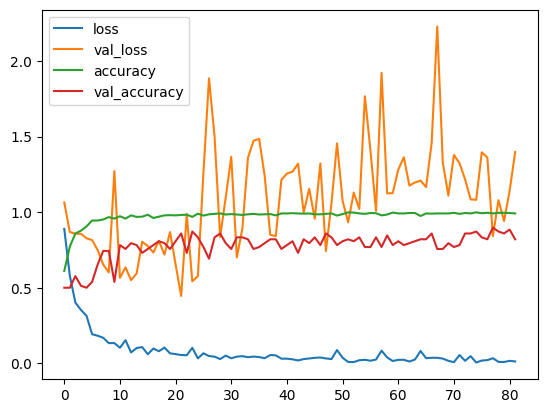

In [ ]:
hist = history.history

plt.plot(hist['loss'], label=  'loss')
plt.plot(hist['val_loss'], label = 'val_loss')
plt.plot(hist['sparse_categorical_accuracy'], label='accuracy')
plt.plot(hist['val_sparse_categorical_accuracy'], label='val_accuracy')
plt.legend()

In [ ]:
incept_model.evaluate(x=x_test, y = y_test, batch_size=32, verbose=1)

3/3 [==============================] - 0s 111ms/step - loss: 1.3979 - sparse_categorical_accuracy: 0.8205


[1.397900104522705, 0.8205128312110901]

In [ ]:
# open train the last 100 layers
for layer in incept_model.layers[720:]:
    layer.trainable = True

# compile the model with new optimizer and lr=.0001
incept_model.compile(optimizer=optimizers.RMSprop(.0001), loss = losses.sparse_categorical_crossentropy, metrics=[metrics.SparseCategoricalAccuracy()])

# incept_model.summary()

In [ ]:


earlyStop = keras.callbacks.EarlyStopping(patience=60)
best_model = keras.callbacks.ModelCheckpoint(filepath='best_model_2.h5', save_best_only=True)

# load the best weights
# incept_model.set_weights(best_weights)

with tf.device('/gpu:0'):
    history = incept_model.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_test, y_test), callbacks=[earlyStop, best_model])



Epoch 1/100
22/22 [==============================] - 7s 183ms/step - loss: 0.0168 - sparse_categorical_accuracy: 0.9957 - val_loss: 1.2974 - val_sparse_categorical_accuracy: 0.8462
Epoch 2/100
22/22 [==============================] - 3s 160ms/step - loss: 0.0039 - sparse_categorical_accuracy: 0.9986 - val_loss: 1.2523 - val_sparse_categorical_accuracy: 0.8846
Epoch 3/100
22/22 [==============================] - 4s 177ms/step - loss: 0.0084 - sparse_categorical_accuracy: 0.9972 - val_loss: 1.1964 - val_sparse_categorical_accuracy: 0.8718
Epoch 4/100
22/22 [==============================] - 4s 161ms/step - loss: 0.0097 - sparse_categorical_accuracy: 0.9972 - val_loss: 1.1811 - val_sparse_categorical_accuracy: 0.8590
Epoch 5/100
22/22 [==============================] - 4s 178ms/step - loss: 0.0084 - sparse_categorical_accuracy: 0.9957 - val_loss: 1.1007 - val_sparse_categorical_accuracy: 0.8590
Epoch 6/100
22/22 [==============================] - 4s 182ms/step - loss: 0.0047 - sparse_cate

In [ ]:
from tensorflow.keras.models import load_model
incept_model=load_model('/content/drive/MyDrive/best_model_2.h5')

In [ ]:
first_layer = incept_model.layers[0]
expected_input_shape = first_layer.input_shape
print('Expected input shape:', expected_input_shape)

Expected input shape: [(None, 224, 224, 3)]


In [ ]:
# used to predict the model and visualize the orignal image with title of true and pred values
def predict_image(img_path, label):
    img1 = prepare_image(img_path) # preprocess the image
    res = incept_model.predict(np.expand_dims(img1, axis = 0)) # predict the image
    pred = classes[np.argmax(res)]

    # Visualize the image
    img = image.load_img(img_path)
    plt.imshow(np.array(img))
    plt.title(f'True: {label}\nPredicted: {pred}')

1/1 [==============================] - 0s 227ms/step


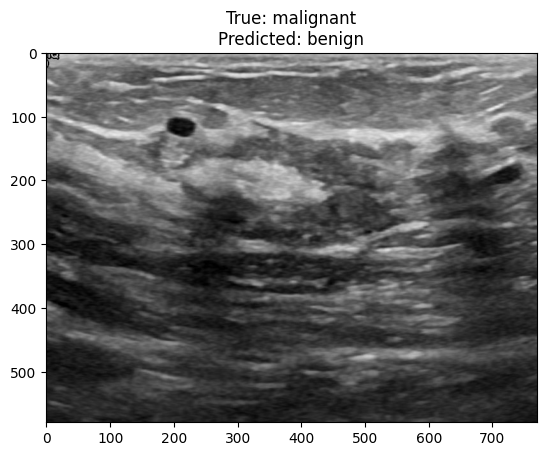

In [ ]:
predict_image('/content/drive/MyDrive/Dataset_BUSI_with_GT/benign/benign (144).png', 'malignant')

1/1 [==============================] - 0s 80ms/step


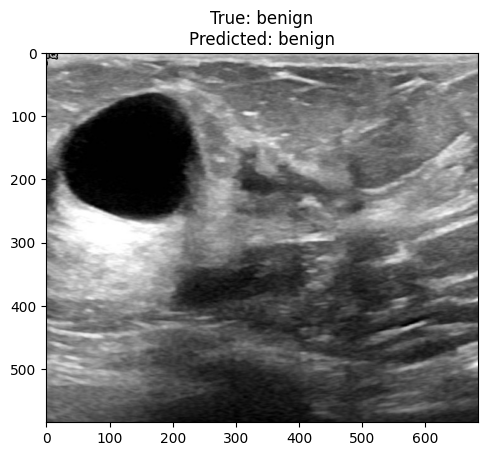

In [ ]:


predict_image('/content/drive/MyDrive/Dataset_BUSI_with_GT/benign/benign (10).png', 'benign')



1/1 [==============================] - 0s 60ms/step


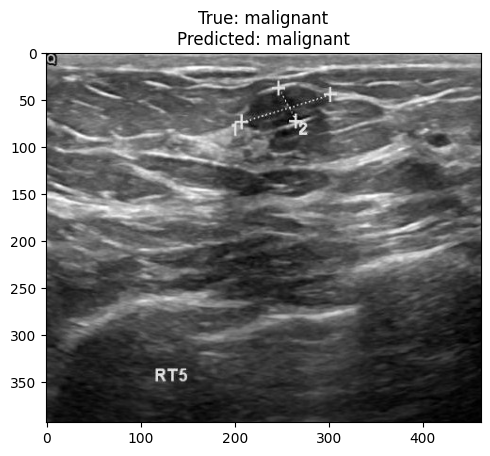

In [ ]:

predict_image('/content/drive/MyDrive/Dataset_BUSI_with_GT/malignant/malignant (10).png', 'malignant')


In [ ]:
incept_model.evaluate(np.array(x_test),np.array(y_test))

3/3 [==============================] - 1s 107ms/step - loss: 0.7756 - sparse_categorical_accuracy: 0.8846


[0.7756186723709106, 0.8846153616905212]

In [ ]:


predicted = []
for item in incept_model.predict(x_test):
    predicted.append(np.argmax(item))



3/3 [==============================] - 0s 139ms/step


In [ ]:


from sklearn.metrics import confusion_matrix
import seaborn as sns
conf = confusion_matrix(y_test,predicted)
conf



array([[36,  1,  2],
       [ 6, 20,  0],
       [ 0,  0, 13]])

Text(0.5, 155.72222222222217, 'Predicted')

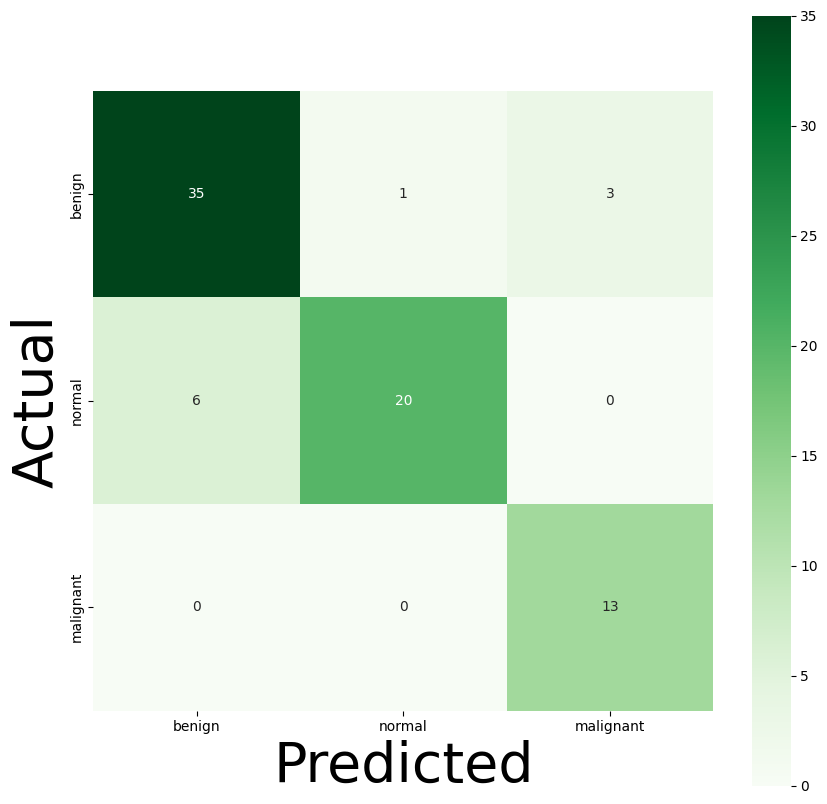

In [ ]:


#Heatmap
info = [
    'benign'   ,  # 0
    'normal'   ,  # 1
    'malignant',  # 2
]
plt.figure(figsize = (10,10))
ax = sns.heatmap(conf, cmap=plt.cm.Greens, annot=True, square=True, xticklabels = info, yticklabels = info)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)



<Axes: >

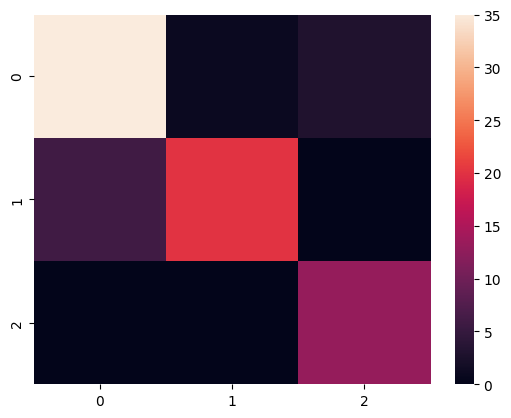

In [ ]:
import seaborn as sns
sns.heatmap(conf)

In [ ]:


from tensorflow.keras.utils import plot_model

plot_model(incept_model, to_file='aug_model_plot.png', show_shapes=True, show_layer_names=True)




In [ ]:
import numpy as np

# Convert y_true and predicted to list or numpy array
if isinstance(y_true, int):
   y_true = [y_true]
if isinstance(predicted, int):
   predicted = [predicted]

# Now compute the F1 score
f1 = f1_score(y_true, predicted, average=None)
print('F1 Score: ', f1)
